
<br>
<font>
<!-- <img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" alt="SUT logo" width=300 height=300 align=left class="saturate"> -->
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=200 height=200>
<br>
<font color=0F5298 size=7>
Machine Learning <br>
<font color=2565AE size=5>
Electrical Engineering Department <br>
Spring 2024<br>
<font color=3C99D size=5>
Practical Assignment 4 <br>
<font color=696880 size=4>
<!-- <br> -->


____

# Personal Data

In [ ]:
student_number = '400101967'
first_name = 'Ehsan'
last_name = 'Merrikhi'

# Introduction

In this assignment, we will be performing clustering on Spotify songs.

# Data Preprocessing

In the next cell, import the libraries you'll need.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In the `spotify.csv` file, load the data. Exclude unrelated features and retain only the track name and the features you believe are relevant.

In [5]:
data = pd.read_csv('spotify.csv')
drop_columns = ['track_id','track_name', 'track_artist', 'track_album_id','track_album_name', 
                'track_album_release_date', 'playlist_name', 'playlist_id']
data = data.drop(columns=drop_columns)
print(data.columns.tolist())

['track_popularity', 'playlist_genre', 'playlist_subgenre', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']


In this cell, you should implement a standard scalar function from scratch and applying it to your data. Explian importance behind using a standard scalar and the potential complications that could arise in clustering if it's not employed. (you can't use `sklearn.preprocessing.StandardScaler` but you are free to use `sklearn.preprocessing.LabelEncoder`)

*Standard Scaling gives us the advantage of being able to compare different features with same metrics*

*This also gives us robustness to outliers and enhances model performance*

In [10]:
from sklearn.preprocessing import LabelEncoder

def std_scaler(data, columns=None):
    if columns == None:
        columns = data.columns.tolist()
    for column in columns:
        avg = data[column].mean()
        std = data[column].std()
        data[column] = (data[column] - avg) / std
    return data

for column in ['playlist_genre', 'playlist_subgenre']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])

data = std_scaler(data)

# Dimensionality Reduction

One method for dimensionality reduction is Principal Component Analysis (PCA). Use its implementation from the `sklearn` library to reduce the dimensions of your data. Then, by using an appropriate cut-off for the `_explained_variance_ratio_` in the PCA algorithm, determine the number of principal components to retain.

*With cutoff = 0.95 of total variance we retained 13 principal components*

In [18]:
from sklearn.decomposition import PCA

pca = PCA()
# data shape before using PCA 
print(f'data shape before reducing dimensions: {data.shape}')
data_pca = pca.fit_transform(data)
explained_var_ratio = pca.explained_variance_ratio_

cumulative_variance_ratio = explained_var_ratio.cumsum()
cutoff_threshold = 0.95  # for 95% explained variance
num_components = next(i for i, total in enumerate(cumulative_variance_ratio) if total >= cutoff_threshold) + 1

# Transform data using selected number of components
pca = PCA(n_components=num_components)
data_reduced = pca.fit_transform(data)
# print(explained_var_ratio)

# print(sum(explained_var_ratio)) # = 1
# PCA data shape after using PCA 
print(f'data shape after reducing dimensions: {data_reduced.shape}')


data shape before reducing dimensions: (32833, 15)
data shape after reducing dimensions: (32833, 13)


# Clustering

Implement K-means for clustering from scratch.

In [21]:
# K-Means implementation
def initialize_centroids(data, k):
    indices = np.random.choice(data.shape[0], k, replace=False)
    return data[indices]

def assign_clusters(data, centroids):
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

def update_centroids(data, labels, k):
    new_centroids = np.zeros((k, data.shape[1]))
    for i in range(k):
        new_centroids[i] = data[labels == i].mean(axis=0)
    return new_centroids

def kmeans(data, k, max_iters=100, tol=1e-4):
    centroids = initialize_centroids(data, k)
    for _ in range(max_iters):
        labels = assign_clusters(data, centroids)
        new_centroids = update_centroids(data, labels, k)
        if np.all(np.abs(new_centroids - centroids) < tol):
            break
        centroids = new_centroids
    return centroids, labels

# Apply K-Means
k = 5  # Number of clusters
centroids, labels = kmeans(data_reduced, k)

Using the function you've created to execute the K-means algorithm eight times on your data, with the number of clusters ranging from 2 to 9. For each run, display the genre of each cluster using the first two principal components in a plot.

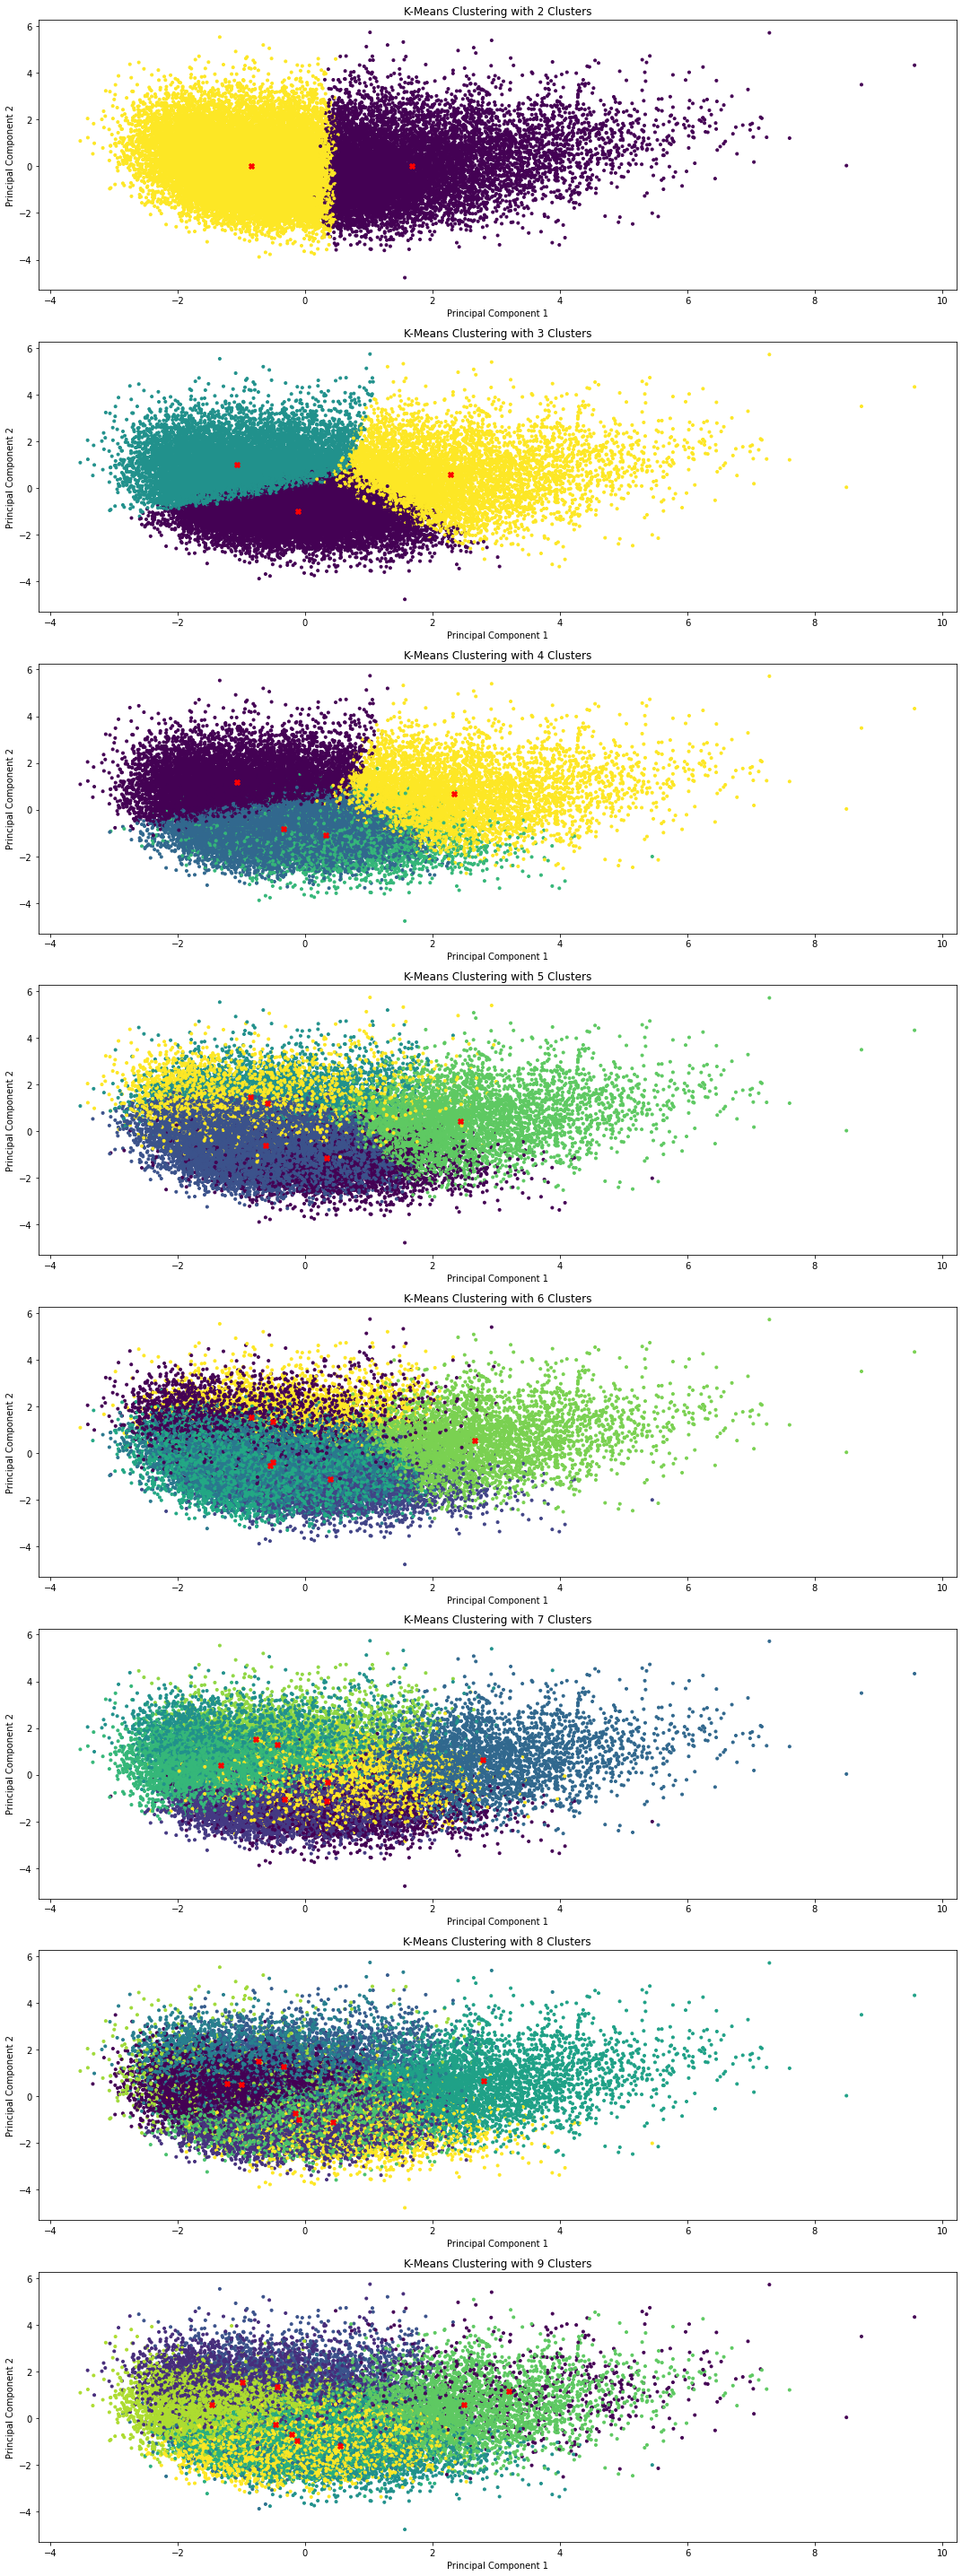

In [22]:
pca_2 = PCA(n_components=2)
data_pca_2 = pca_2.fit_transform(data_reduced)

plt.figure(figsize=(15, 40))
for k in range(2, 10):
    centroids, labels = kmeans(data_reduced, k)
    
    plt.subplot(8, 1, k - 1)
    plt.scatter(data_pca_2[:, 0], data_pca_2[:, 1], c=labels, cmap='viridis', marker='.')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'K-Means Clustering with {k} Clusters')
plt.tight_layout()
plt.show()

The Silhouette score and the Within-Cluster Sum of Squares (WSS) score are two metrics used to assess the quality of your clustering. You can find more information about these two methods [here](https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb). Plot the Silhouette score and the WSS score for varying numbers of clusters, and use these plots to determine the optimal number of clusters (k).

*Based on these plots, the optimal number of clusters seems to be either 3 or 5. If a single choice is required, k=3 is typically favored due to the clearer "elbow" indication in the WSS plot. However, k=5 should also be considered based on the local peak in the Silhouette Score. I prefer to chose k=5 because of silhouette_score*


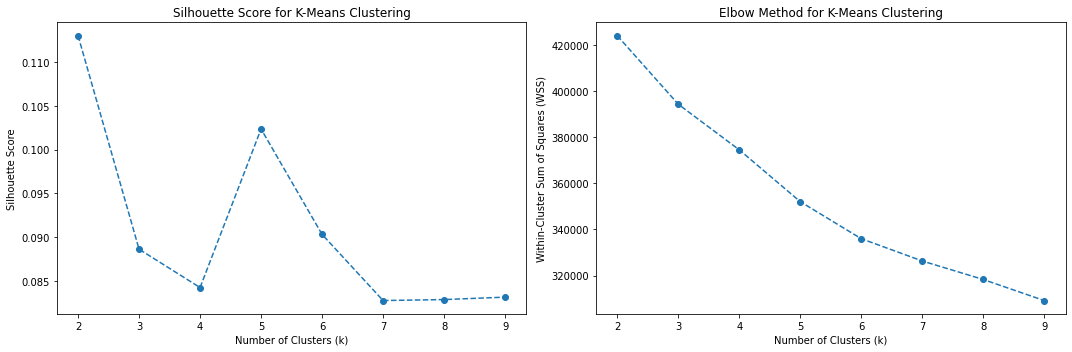

In [23]:
from sklearn.metrics import silhouette_score

# Function to calculate WSS (Within-Cluster Sum of Squares)
def calculate_wss(data, labels, centroids):
    wss = 0
    for i in range(len(centroids)):
        cluster_points = data[labels == i]
        wss += np.sum((cluster_points - centroids[i]) ** 2)
    return wss

# Lists to store the scores
silhouette_scores = []
wss_scores = []

# Loop over the range of cluster numbers
for k in range(2, 10):
    centroids, labels = kmeans(data_reduced, k)
    silhouette_avg = silhouette_score(data_reduced, labels)
    wss = calculate_wss(data_reduced, labels, centroids)
    
    silhouette_scores.append(silhouette_avg)
    wss_scores.append(wss)

# Plotting the Silhouette scores
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, 10), silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for K-Means Clustering')

# Plotting the WSS scores (Elbow Method)
plt.subplot(1, 2, 2)
plt.plot(range(2, 10), wss_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WSS)')
plt.title('Elbow Method for K-Means Clustering')

plt.tight_layout()
plt.show()


# Checking Output

To see how good was our clustering we will use a sample check and t-SNE method.

first randomly select two song from every cluster and see how close these two songs are.

In [31]:
import numpy as np

def sample_check(data, labels, k):
    np.random.seed(67)  # for reproducibility
    for cluster_id in range(k):
        cluster_indices = np.where(labels == cluster_id)[0]
        if len(cluster_indices) < 2:
            print(f"Cluster {cluster_id} has less than 2 items, skipping sample check.")
            continue
        
        sampled_indices = np.random.choice(cluster_indices, 2, replace=False)
        song1, song2 = data[sampled_indices]
        
        distance = np.linalg.norm(song1 - song2)
        print(f"Cluster {cluster_id}: Distance between two randomly selected songs: {distance:.2f}")

# Run sample check for k = 3 and k = 5
k = 3
centroids, labels = kmeans(data_reduced, k)
sample_check(data_reduced, labels, k)

print()
k = 5
centroids, labels = kmeans(data_reduced, k)
sample_check(data_reduced, labels, k)

Cluster 0: Distance between two randomly selected songs: 5.73
Cluster 1: Distance between two randomly selected songs: 6.94
Cluster 2: Distance between two randomly selected songs: 4.68

Cluster 0: Distance between two randomly selected songs: 6.30
Cluster 1: Distance between two randomly selected songs: 4.41
Cluster 2: Distance between two randomly selected songs: 5.02
Cluster 3: Distance between two randomly selected songs: 5.15
Cluster 4: Distance between two randomly selected songs: 4.46


Using t-SNE reduce dimension of data pointe to 2D and plot it to check how good datapoints are clustered (implementing this part is optional and have extra points)

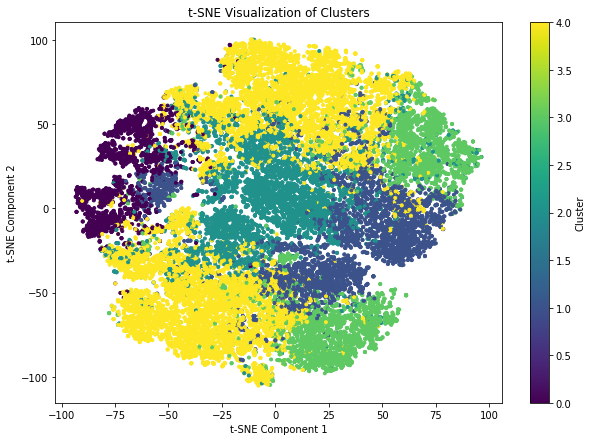

In [30]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=67)
data_tsne = tsne.fit_transform(data_reduced)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 7))
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=labels, cmap='viridis', marker='.')
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()